# Ch3 | Self-Attention：让词向量在上下文中"流动"

---

**目标：** 理解自注意力机制的工作原理

**核心问题：** 如何让词向量根据上下文动态变化？

---

## 本章内容

1. **为什么需要 Attention**：静态 Embedding 的局限
2. **手写 Attention**：从零实现 Q, K, V
3. **可视化**：注意力权重热力图
4. **Masked Attention**：为什么不能"偷看答案"？

---

## 🎓 前置知识：语言理解的挑战

### Embedding 的局限性

上一章我们学习了 Embedding，但它有一个大问题：

```
"苹果很好吃"  →  苹果 = [0.2, 0.8, ...]  (水果)
"苹果发布新手机"  →  苹果 = [0.2, 0.8, ...]  (同样的向量！)
```

**问题：同一个词在不同语境下含义不同，但 Embedding 是固定的！**

### 语境的重要性

人类理解语言时，会根据**上下文**来理解每个词：

```
"我喜欢吃苹果"  →  苹果 = 水果 🍎
"我在用苹果手机"  →  苹果 = 公司 
```

### 如何让模型"看上下文"？

**Self-Attention（自注意力）**：让每个词**看看周围的词**，然后根据上下文调整自己的表示。

核心思想：
```
静态 Embedding:  苹果 → [固定向量]
+
Self-Attention:  苹果 + "我喜欢吃" → [动态向量，表示水果]
                 苹果 + "发布新手机" → [动态向量，表示公司]
```

### 本章目标

- 理解为什么需要 Attention
- 掌握 Q (Query), K (Key), V (Value) 的直觉
- 实现 Self-Attention 并可视化注意力权重
- 理解 Causal Mask（为什么不能"偷看未来"）

## 0. 环境准备

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import font_manager as fm
import matplotlib as mpl
font_path = "../assets/fonts/NotoSansCJKsc-Regular.otf"
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Noto Sans CJK SC", "DejaVu Sans"]
mpl.rcParams["axes.unicode_minus"] = False
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0+cu128


---

## 1. 为什么需要 Attention？

### 静态 Embedding 的问题

考虑这两个句子：
- "苹果很好吃" （水果）
- "苹果发布了新手机" （公司）

静态 Embedding 中，"苹果"只有一个固定向量，无法区分两种含义！

### 解决方案：Self-Attention

让每个词"看看"周围的词，然后根据上下文调整自己的表示。

```
静态 Embedding: 苹果 → [固定向量]
动态 Attention: 苹果 + 上下文 → [动态向量]
```

---

## 2. 手写 Self-Attention

### 核心公式

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V$$

- **Q (Query)**: 我在找什么？
- **K (Key)**: 我有什么？
- **V (Value)**: 我的内容是什么？

简单理解：
1. Q 和 K 点积 → 计算"关注度"
2. Softmax → 转换为概率分布
3. 用概率加权 V → 得到最终输出

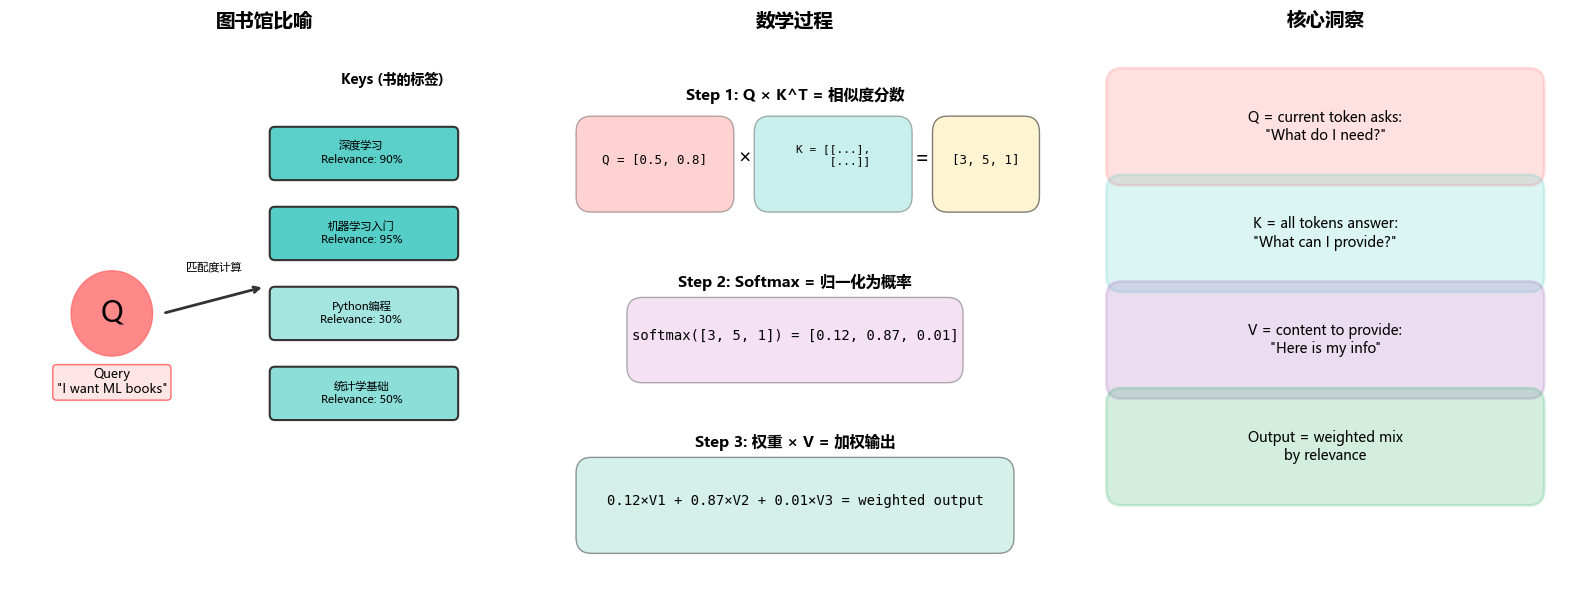


Key takeaways:
   Q*K^T -> who to attend to (attention scores)
   Softmax -> how much to attend (probabilities)
   *V -> mix values by attention (weighted sum)


In [ ]:
# Q/K/V 直观理解：图书馆比喻
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Noto Sans CJK SC", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

def visualize_qkv_intuition():
    """
    用图书馆比喻来解释 Q/K/V
    - Query: 你想找什么书？
    - Key: 书架上书的标签
    - Value: 书的实际内容
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))

    # ===== Scene 1: Library analogy =====
    ax = axes[0]
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    ax.set_title('图书馆比喻', fontsize=14, fontweight='bold', pad=15)

    # Person (Query)
    ax.add_patch(plt.Circle((2, 5), 0.8, color='#FF6B6B', alpha=0.8))
    ax.text(2, 5, 'Q', fontsize=20, ha='center', va='center')
    ax.text(2, 3.5, 'Query\n"I want ML books"', fontsize=9, ha='center',
           bbox=dict(boxstyle='round', facecolor='#FFE5E5', edgecolor='#FF6B6B'))

    # Shelf (Keys)
    books = [
        (6, 8, '深度学习', 0.9),
        (6, 6.5, '机器学习入门', 0.95),
        (6, 5, 'Python编程', 0.3),
        (6, 3.5, '统计学基础', 0.5),
    ]

    for x, y, label, score in books:
        color_intensity = 0.3 + 0.7 * score
        ax.add_patch(FancyBboxPatch((x-0.8, y-0.4), 3.5, 0.8,
                                    boxstyle='round,pad=0.1',
                                    facecolor=(78/255, 205/255, 196/255, color_intensity),
                                    edgecolor='#333', linewidth=1.5))
        ax.text(x+0.9, y, f'{label}\nRelevance: {score:.0%}', fontsize=8, ha='center', va='center')

    ax.text(7.5, 9.3, 'Keys (书的标签)', fontsize=10, ha='center', fontweight='bold')

    # Arrows
    ax.annotate('', xy=(5, 5.5), xytext=(3, 5),
               arrowprops=dict(arrowstyle='->', color='#333', lw=2))
    ax.text(4, 5.8, '匹配度计算', fontsize=8, ha='center')

    # ===== Scene 2: Math steps =====
    ax = axes[1]
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    ax.set_title('数学过程', fontsize=14, fontweight='bold', pad=15)

    # Step 1
    ax.text(5, 9, 'Step 1: Q × K^T = 相似度分数', fontsize=11, ha='center', fontweight='bold')
    ax.add_patch(FancyBboxPatch((1, 7.2), 2.5, 1.2, boxstyle='round', facecolor='#FF6B6B', alpha=0.3))
    ax.text(2.25, 7.8, 'Q = [0.5, 0.8]', fontsize=9, ha='center', family='monospace')

    ax.text(4, 7.8, '×', fontsize=14, ha='center')

    ax.add_patch(FancyBboxPatch((4.5, 7.2), 2.5, 1.2, boxstyle='round', facecolor='#4ECDC4', alpha=0.3))
    ax.text(5.75, 7.8, 'K = [[...],\n     [...]]', fontsize=8, ha='center', family='monospace')

    ax.text(7.5, 7.8, '=', fontsize=14, ha='center')

    ax.add_patch(FancyBboxPatch((8, 7.2), 1.5, 1.2, boxstyle='round', facecolor='#FFEAA7', alpha=0.5))
    ax.text(8.75, 7.8, '[3, 5, 1]', fontsize=9, ha='center', family='monospace')

    # Step 2
    ax.text(5, 5.5, 'Step 2: Softmax = 归一化为概率', fontsize=11, ha='center', fontweight='bold')
    ax.add_patch(FancyBboxPatch((2, 4), 6, 1, boxstyle='round', facecolor='#DDA0DD', alpha=0.3))
    ax.text(5, 4.5, 'softmax([3, 5, 1]) = [0.12, 0.87, 0.01]', fontsize=10, ha='center', family='monospace')

    # Step 3
    ax.text(5, 2.5, 'Step 3: 权重 × V = 加权输出', fontsize=11, ha='center', fontweight='bold')
    ax.add_patch(FancyBboxPatch((1, 0.8), 8, 1.2, boxstyle='round', facecolor='#98D8C8', alpha=0.4))
    ax.text(5, 1.4, '0.12×V1 + 0.87×V2 + 0.01×V3 = weighted output', fontsize=10, ha='center', family='monospace')

    # ===== Scene 3: Key intuition =====
    ax = axes[2]
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    ax.set_title('核心洞察', fontsize=14, fontweight='bold', pad=15)

    insights = [
        (5, 8.5, 'Q = current token asks:\n"What do I need?"', '#FF6B6B'),
        (5, 6.5, 'K = all tokens answer:\n"What can I provide?"', '#4ECDC4'),
        (5, 4.5, 'V = content to provide:\n"Here is my info"', '#9B59B6'),
        (5, 2.5, 'Output = weighted mix\nby relevance', '#27AE60'),
    ]

    for x, y, text, color in insights:
        ax.add_patch(FancyBboxPatch((1, y-0.8), 8, 1.6, boxstyle='round,pad=0.3',
                                    facecolor=color, alpha=0.2, edgecolor=color, linewidth=2))
        ax.text(x, y, text, fontsize=10, ha='center', va='center')

    plt.tight_layout()
    plt.show()

    print("\nKey takeaways:")
    print("   Q*K^T -> who to attend to (attention scores)")
    print("   Softmax -> how much to attend (probabilities)")
    print("   *V -> mix values by attention (weighted sum)")

visualize_qkv_intuition()

![attention_alammar](attention_alammar.png)

来源：Alammar 的可视化示意图 https://jalammar.github.io/illustrated-transformer/


### 从 scores 到 z 的计算过程

设输入 `x` 形状为 `[batch, seq_len, d_model]`，这里最简版本取 `Q=K=V=x`。下面按数字步骤绘制整个计算链路：

1. **计算相似度得分（scores）**
   $$\text{scores} = Q K^T$$
   对每个 batch，每个 query 位置 $i$ 与所有 key 位置 $j$ 做点积：
   $$\text{scores}_{i,j} = \sum_{d=1}^{d_k} Q_{i,d} K_{j,d}$$
   得到形状 `[batch, seq_len, seq_len]`，表示每个 query 对所有 key 的原始匹配分。

2. **缩放 scores（scaled scores）**
   $$\text{scores} = \frac{\text{scores}}{\sqrt{d_k}}$$
   用 $\\sqrt{d_k}$ 进行归一化，避免点积随维度增大而过度放大，使 softmax 更稳定。

3. **Softmax 得到注意力权重**
   $$A = \text{softmax}(\text{scores})$$
   在最后一维（key 维度）做 softmax，每一行是一个概率分布，满足各行和为 1。

4. **加权求和得到输出（z）**
   $$z = A V$$
   等价于对每个 query 位置 $i$：
   $$z_i = \sum_{j=1}^{seq\_len} A_{i,j} V_j$$
   输出 `z` 的形状为 `[batch, seq_len, d_model]`，就是连接上下文后的新表示。

代码对照：`scores -> attention_weights -> output` 就对应上面的 `scores -> A -> z`。

### 按图中的例子（input -> Q/K/V -> z）

设 d_k=64，因此 $\sqrt{d_k}=8$。为了对齐图里的分数，构造一个简单的数值输入，并取 $W_q=W_k=W_v=I$（所以 Q=K=V=x）。

**0) input x（64 维向量，所有维度取相同数值）**
```
x1 = [1.323, 1.323, ..., 1.323]  (64 维)
x2 = [1.134, 1.134, ..., 1.134]  (64 维)
```

**1) Q, K, V**
```
q1 = k1 = v1 = x1
q2 = k2 = v2 = x2
```

**2) scores = Q K^T（图中给的 112 和 96）**
```
q1 · k1 = 64 * 1.323 * 1.323 ≈ 112
q1 · k2 = 64 * 1.323 * 1.134 ≈ 96
```

**3) scaled scores = scores / sqrt(d_k)**
```
[112, 96] / 8 = [14, 12]
```

**4) attention weights = softmax([14, 12])**
```
exp(14)=1.202e6, exp(12)=1.627e5, sum=1.365e6
A = [0.881, 0.119]  (≈ [0.88, 0.12])
```

**5) z1 = A V（对应图里的 z1）**
```
z1 = 0.881*v1 + 0.119*v2
每一维 = 0.881*1.323 + 0.119*1.134 ≈ 1.300
z1 = [1.300, 1.300, ..., 1.300]  (64 维)
```

图中展示的是 q1 对 k1/k2 的计算，q2 同理。


In [ ]:
def self_attention(x, d_k):
    """
    最简单的 Self-Attention 实现
    
    x: [batch, seq_len, d_model] 输入序列
    d_k: 注意力维度
    
    返回: [batch, seq_len, d_model] 加权后的输出
    """
    batch_size, seq_len, d_model = x.shape
    
    # 为简单起见，Q=K=V=x（实际中会有投影矩阵）
    Q = x  # [batch, seq_len, d_model]
    K = x
    V = x
    
    # 1. 计算注意力分数: Q @ K^T
    scores = torch.matmul(Q, K.transpose(-2, -1))  # [batch, seq_len, seq_len]
    
    # 2. 缩放（防止点积过大）
    scores = scores / np.sqrt(d_k)
    
    # 3. Softmax 得到注意力权重
    attention_weights = F.softmax(scores, dim=-1)  # [batch, seq_len, seq_len]
    
    # 4. 加权求和
    output = torch.matmul(attention_weights, V)  # [batch, seq_len, d_model]
    
    return output, attention_weights

# 测试
batch_size, seq_len, d_model = 1, 5, 8
x = torch.randn(batch_size, seq_len, d_model)

output, weights = self_attention(x, d_k=d_model)

print(f"输入形状: {x.shape}")
print(f"输出形状: {output.shape}")
print(f"注意力权重形状: {weights.shape}")

输入形状: torch.Size([1, 5, 8])
输出形状: torch.Size([1, 5, 8])
注意力权重形状: torch.Size([1, 5, 5])


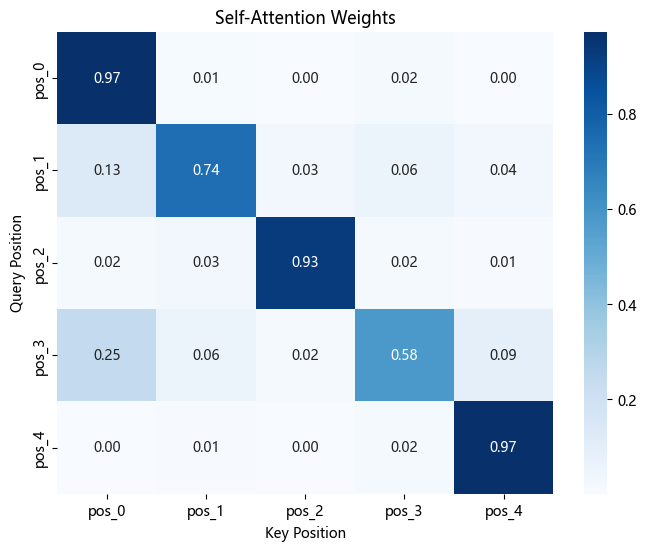

每行和为1（概率分布）: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [ ]:
# 可视化注意力权重
plt.figure(figsize=(8, 6))
sns.heatmap(weights[0].detach().numpy(), 
            annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[f'pos_{i}' for i in range(seq_len)],
            yticklabels=[f'pos_{i}' for i in range(seq_len)])
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Self-Attention Weights')
plt.show()

print("每行和为1（概率分布）:", weights[0].sum(dim=-1))

---

## 3. 标准 Self-Attention 实现（带投影矩阵）

In [7]:
class SelfAttention(nn.Module):
    """
    标准的 Self-Attention 层
    """
    def __init__(self, d_model, d_k=None):
        super().__init__()
        self.d_k = d_k or d_model
        
        # Q, K, V 投影矩阵
        self.W_q = nn.Linear(d_model, self.d_k, bias=False)
        self.W_k = nn.Linear(d_model, self.d_k, bias=False)
        self.W_v = nn.Linear(d_model, self.d_k, bias=False)
        
        # 输出投影
        self.W_o = nn.Linear(self.d_k, d_model, bias=False)
    
    def forward(self, x, mask=None):
        # x: [batch, seq_len, d_model]
        
        # 投影得到 Q, K, V
        Q = self.W_q(x)  # [batch, seq_len, d_k]
        K = self.W_k(x)
        V = self.W_v(x)
        
        # 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        # 可选: 应用 mask
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        # Softmax
        attention_weights = F.softmax(scores, dim=-1)
        
        # 加权求和
        context = torch.matmul(attention_weights, V)
        
        # 输出投影
        output = self.W_o(context)
        
        return output, attention_weights

# 创建并测试
attention = SelfAttention(d_model=32, d_k=16)
x = torch.randn(2, 10, 32)  # 2个句子，每句10个词，每词32维

output, weights = attention(x)
print(f"输入: {x.shape}")
print(f"输出: {output.shape}")
print(f"参数量: {sum(p.numel() for p in attention.parameters())}")

输入: torch.Size([2, 10, 32])
输出: torch.Size([2, 10, 32])
参数量: 2048


---

## 4. Masked Attention：防止"偷看答案"

在语言模型中，生成第 t 个词时，只能看到前面的词（1 到 t-1），不能看到后面的词。

这就需要 **Causal Mask（因果掩码）**。

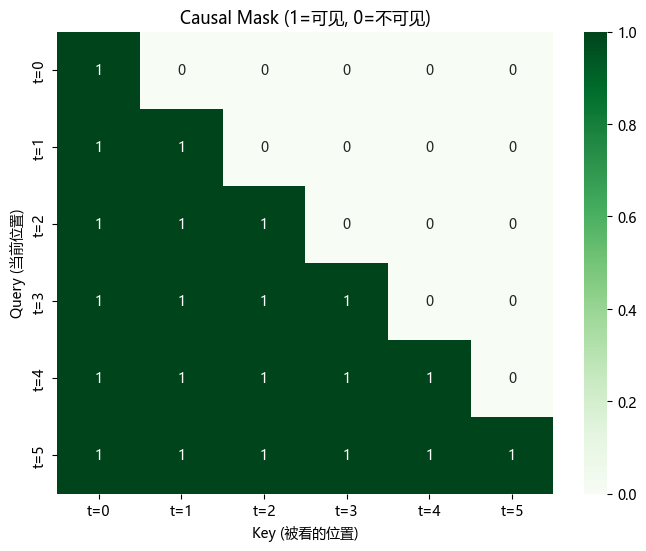

解释：
  t=0 时，只能看自己
  t=1 时，能看 t=0 和 t=1
  t=5 时，能看所有位置


In [8]:
def create_causal_mask(seq_len):
    """
    创建下三角掩码矩阵
    1 = 可以看
    0 = 不能看（会被设为 -inf）
    """
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask

# 可视化 mask
seq_len = 6
mask = create_causal_mask(seq_len)

plt.figure(figsize=(8, 6))
sns.heatmap(mask.numpy(), annot=True, fmt='.0f', cmap='Greens',
            xticklabels=[f't={i}' for i in range(seq_len)],
            yticklabels=[f't={i}' for i in range(seq_len)])
plt.xlabel('Key (被看的位置)')
plt.ylabel('Query (当前位置)')
plt.title('Causal Mask (1=可见, 0=不可见)')
plt.show()

print("解释：")
print("  t=0 时，只能看自己")
print("  t=1 时，能看 t=0 和 t=1")
print("  t=5 时，能看所有位置")

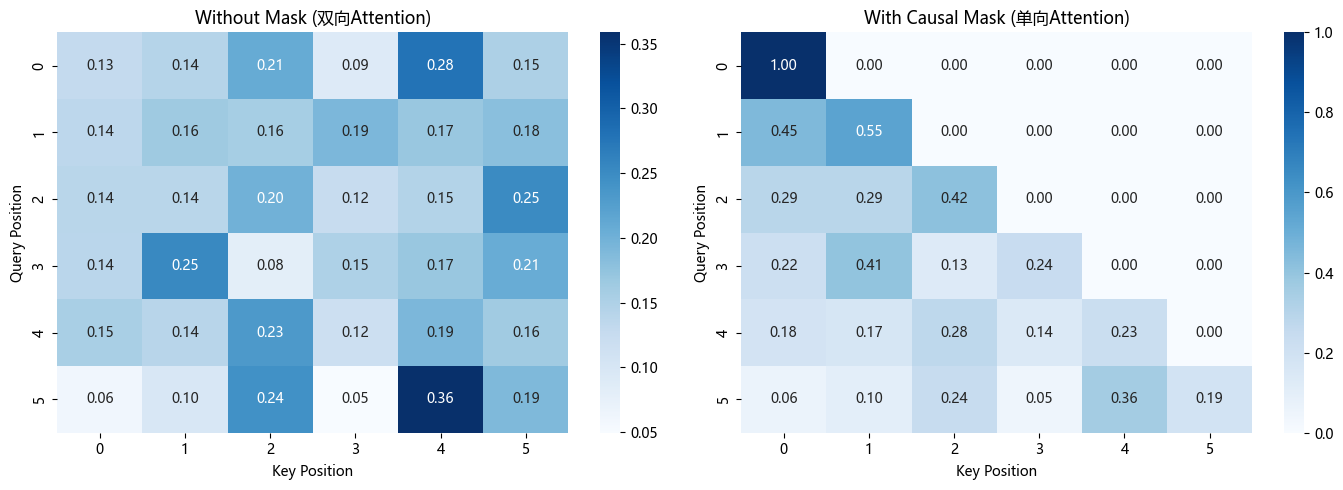

观察：有 Mask 时，上三角部分权重为 0（不能偷看未来）


In [9]:
# 应用 Causal Mask 的效果
x = torch.randn(1, 6, 32)
attention = SelfAttention(d_model=32, d_k=16)

# 无 mask
output_no_mask, weights_no_mask = attention(x)

# 有 mask
mask = create_causal_mask(6).unsqueeze(0)  # [1, 6, 6]
output_masked, weights_masked = attention(x, mask)

# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(weights_no_mask[0].detach().numpy(), ax=axes[0],
            annot=True, fmt='.2f', cmap='Blues')
axes[0].set_title('Without Mask (双向Attention)')
axes[0].set_xlabel('Key Position')
axes[0].set_ylabel('Query Position')

sns.heatmap(weights_masked[0].detach().numpy(), ax=axes[1],
            annot=True, fmt='.2f', cmap='Blues')
axes[1].set_title('With Causal Mask (单向Attention)')
axes[1].set_xlabel('Key Position')
axes[1].set_ylabel('Query Position')

plt.tight_layout()
plt.show()

print("观察：有 Mask 时，上三角部分权重为 0（不能偷看未来）")

---

## 5. Multi-Head Attention：多头注意力

In [10]:
class MultiHeadAttention(nn.Module):
    """
    多头注意力：多个 Attention 并行，然后拼接
    """
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape
        
        # 1. 线性投影
        Q = self.W_q(x)  # [batch, seq_len, d_model]
        K = self.W_k(x)
        V = self.W_v(x)
        
        # 2. 分割成多个头
        # [batch, seq_len, d_model] -> [batch, n_heads, seq_len, d_k]
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # 3. 计算注意力
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attention_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, V)
        
        # 4. 拼接多个头
        # [batch, n_heads, seq_len, d_k] -> [batch, seq_len, d_model]
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        
        # 5. 输出投影
        output = self.W_o(context)
        
        return output, attention_weights

# 测试
mha = MultiHeadAttention(d_model=64, n_heads=8)
x = torch.randn(2, 10, 64)
output, weights = mha(x)

print(f"输入: {x.shape}")
print(f"输出: {output.shape}")
print(f"注意力权重: {weights.shape}  (8个头，每个头10x10)")

输入: torch.Size([2, 10, 64])
输出: torch.Size([2, 10, 64])
注意力权重: torch.Size([2, 8, 10, 10])  (8个头，每个头10x10)


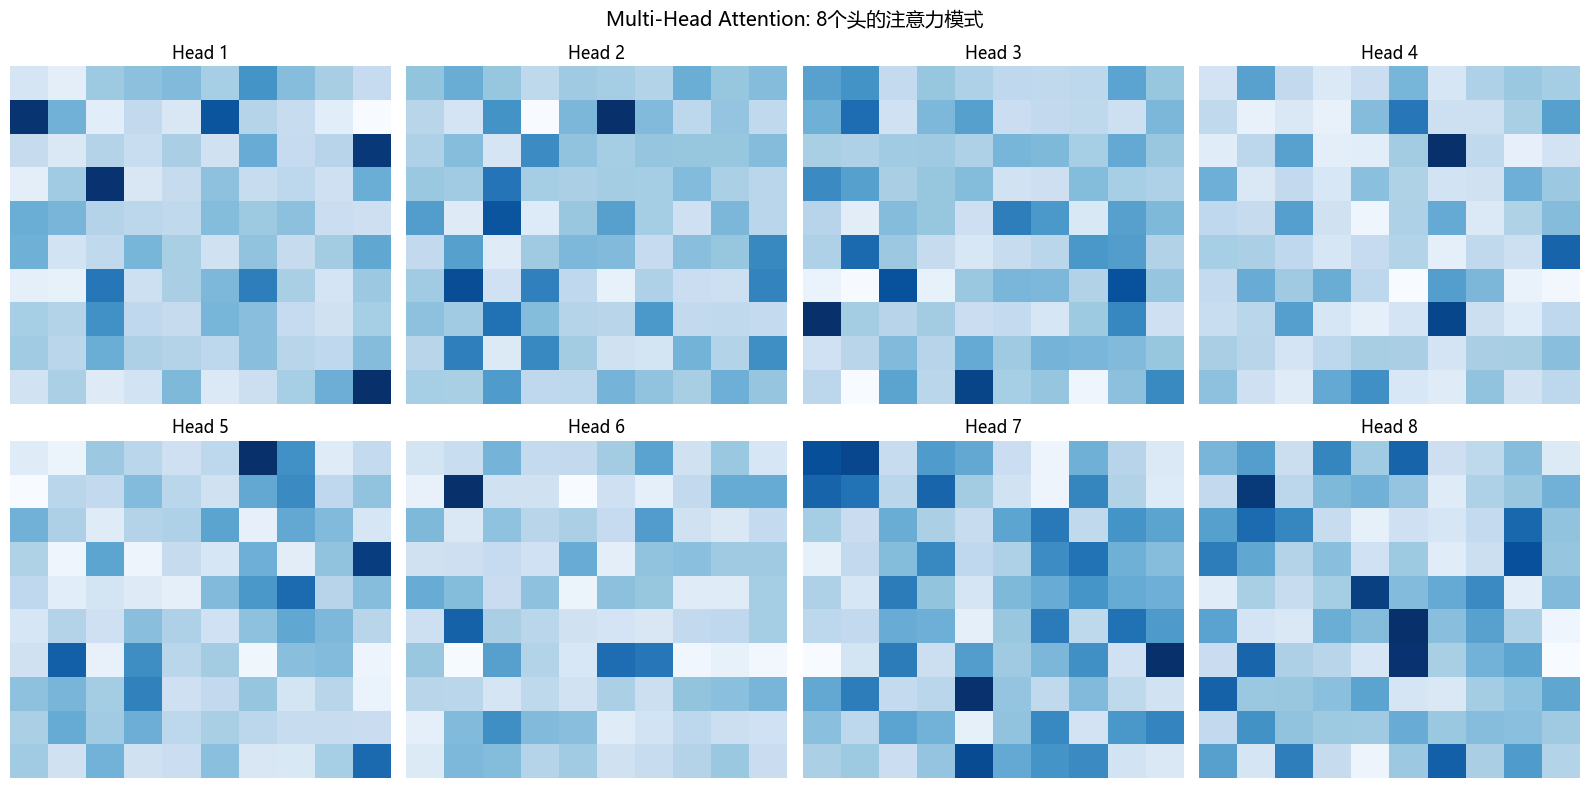

观察：不同的头学习了不同的注意力模式！


In [11]:
# 可视化不同头的注意力模式
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    sns.heatmap(weights[0, i].detach().numpy(), ax=axes[i],
                cmap='Blues', cbar=False)
    axes[i].set_title(f'Head {i+1}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.suptitle('Multi-Head Attention: 8个头的注意力模式', fontsize=14)
plt.tight_layout()
plt.show()

print("观察：不同的头学习了不同的注意力模式！")

---

## 6. 用真实文本演示 Attention

让我们看看 Attention 在真实文本上的效果。

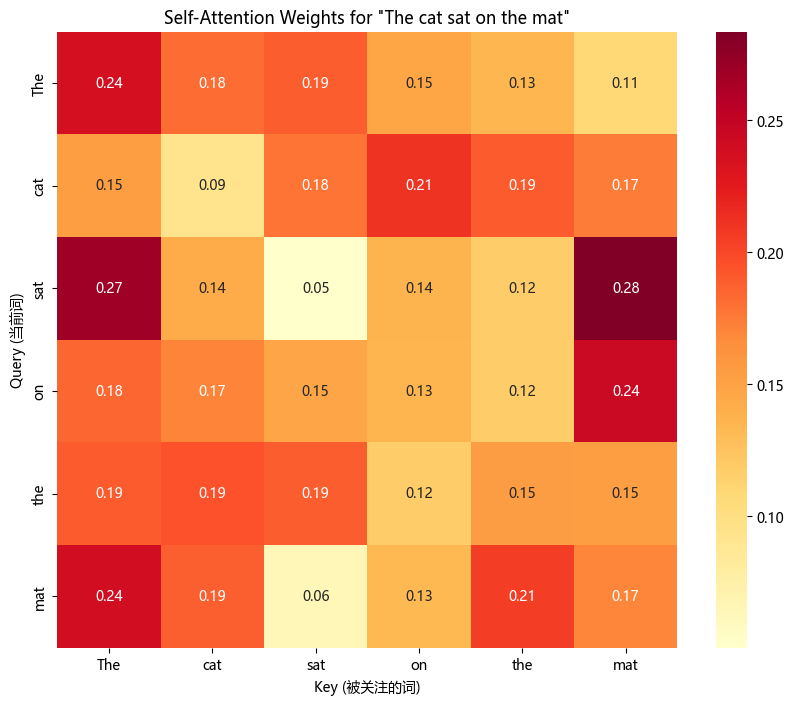

解读：
  - 每一行代表某个词关注其他所有词的程度
  - 权重高表示这两个词关系更密切


In [12]:
# 模拟一个简单的句子编码
sentence = ["The", "cat", "sat", "on", "the", "mat"]
seq_len = len(sentence)

# 假设我们有预训练的词向量
d_model = 32
embeddings = torch.randn(seq_len, d_model)  # 模拟 embedding

# 应用 self-attention
attention = SelfAttention(d_model=d_model, d_k=16)
output, weights = attention(embeddings.unsqueeze(0))

# 可视化
plt.figure(figsize=(10, 8))
sns.heatmap(weights[0].detach().numpy(), 
            annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=sentence,
            yticklabels=sentence)
plt.xlabel('Key (被关注的词)')
plt.ylabel('Query (当前词)')
plt.title('Self-Attention Weights for "The cat sat on the mat"')
plt.show()

print("解读：")
print("  - 每一行代表某个词关注其他所有词的程度")
print("  - 权重高表示这两个词关系更密切")

---

## 本章总结


1. **Self-Attention 的本质**
   - Q, K, V 三个投影
   - 通过点积计算相似度
   - Softmax 转换为概率
   - 加权求和得到上下文感知的表示

2. **Causal Mask**
   - 防止模型"偷看未来"
   - 用下三角矩阵实现

3. **Multi-Head Attention**
   - 多个 Attention 头并行
   - 每个头学习不同的关注模式
   - 最后拼接输出



---

## 思考

1. **修改 d_k**：尝试不同的注意力维度，观察效果
2. **可视化真实模型**：用 HuggingFace 的模型提取注意力权重并可视化
3. **思考**：为什么要除以 √d_k？不除会怎样？
4. 同样的，我们想计算q2的分数和z2如何计算？

In [ ]:
# 练习空间

